In [1]:
import pandas as pd

df = pd.read_csv("../data/raw/creditcard.csv")

class_counts = df["Class"].value_counts()
class_percent = df["Class"].value_counts(normalize=True) * 100

print("Class Distribution")
print("=" * 40)
print(f"Legitimate (0): {class_counts[0]:,} ({class_percent[0]:.4f}%)")
print(f"Fraudulent (1): {class_counts[1]:,} ({class_percent[1]:.4f}%)")
print(f"\nImbalance Ratio: 1:{class_counts[0] // class_counts[1]}")

Class Distribution
Legitimate (0): 284,315 (99.8273%)
Fraudulent (1): 492 (0.1727%)

Imbalance Ratio: 1:577


**Conclusion:**

The dataset is **highly imbalanced** — only **0.17%** of transactions are fraudulent (1 in every 577 samples).

If we model using this data there are high chances that our model will almost always predict the legitimate cases. While training the model, because majority of the class labels are usually legitimate it will be more biased towards predicting them.

## SMOTE (Synthetic Minority Oversampling Technique)

SMOTE is a technique to handle class imbalance by **generating synthetic samples** for the minority class (fraud) rather than simply duplicating existing ones.

**How SMOTE works:**
1. For each minority sample, find its **k nearest neighbors** (default k=5) in the feature space
2. Randomly pick one of those neighbors
3. Create a **new synthetic sample** at a random point on the line segment between the original sample and the chosen neighbor
4. Repeat until the minority class is balanced with the majority class

**Why SMOTE over Random Oversampling?**
- **Random Oversampling** duplicates existing fraud samples exactly → leads to **overfitting** (model memorizes the same few fraud cases)
- **SMOTE** creates new, slightly different samples → model learns a **broader decision boundary** around fraud patterns

**Important:**
- SMOTE must be applied **only on the training set**, never on the test set. Otherwise we leak synthetic data into evaluation and get misleading metrics.
- After SMOTE, the training set will have a **50:50 class ratio** (equal fraud and legitimate samples)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Separate features and target
X = df.drop("Class", axis=1)
y = df["Class"]

# Scale Time and Amount (V1-V28 already scaled via PCA)
scaler = StandardScaler()
X["Scaled_Amount"] = scaler.fit_transform(X["Amount"].values.reshape(-1, 1))
X["Scaled_Time"] = scaler.fit_transform(X["Time"].values.reshape(-1, 1))
X.drop(["Time", "Amount"], axis=1, inplace=True)

# Train-Test Split (stratified to preserve fraud ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Before SMOTE:")
print(f"  Training set: {X_train.shape[0]:,} samples")
print(f"  Legitimate:   {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.4f}%)")
print(f"  Fraudulent:   {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.4f}%)")

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE:")
print(f"  Training set: {X_train_smote.shape[0]:,} samples")
print(f"  Legitimate:   {(y_train_smote == 0).sum():,} ({(y_train_smote == 0).mean()*100:.2f}%)")
print(f"  Fraudulent:   {(y_train_smote == 1).sum():,} ({(y_train_smote == 1).mean()*100:.2f}%)")
print(f"\n  Test set (untouched): {X_test.shape[0]:,} samples")

Before SMOTE:
  Training set: 227,845 samples
  Legitimate:   227,451 (99.8271%)
  Fraudulent:   394 (0.1729%)

After SMOTE:
  Training set: 454,902 samples
  Legitimate:   227,451 (50.00%)
  Fraudulent:   227,451 (50.00%)

  Test set (untouched): 56,962 samples


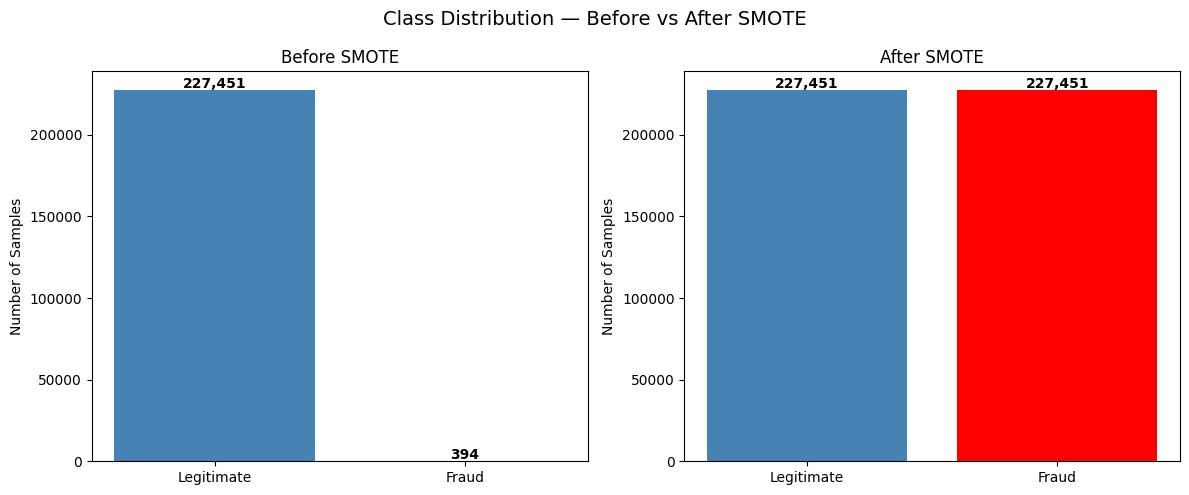

In [3]:
# Visualize class distribution: Before vs After SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(["Legitimate", "Fraud"], [y_train.value_counts()[0], y_train.value_counts()[1]], color=["steelblue", "red"])
axes[0].set_title("Before SMOTE")
axes[0].set_ylabel("Number of Samples")
for i, v in enumerate([y_train.value_counts()[0], y_train.value_counts()[1]]):
    axes[0].text(i, v + 1000, f"{v:,}", ha="center", fontweight="bold")

axes[1].bar(["Legitimate", "Fraud"], [y_train_smote.value_counts()[0], y_train_smote.value_counts()[1]], color=["steelblue", "red"])
axes[1].set_title("After SMOTE")
axes[1].set_ylabel("Number of Samples")
for i, v in enumerate([y_train_smote.value_counts()[0], y_train_smote.value_counts()[1]]):
    axes[1].text(i, v + 1000, f"{v:,}", ha="center", fontweight="bold")

plt.suptitle("Class Distribution — Before vs After SMOTE", fontsize=14)
plt.tight_layout()
plt.show()

## Random Undersampling

Random Undersampling is the opposite approach to SMOTE — instead of creating more minority samples, we **reduce the majority class** to match the minority class count.

**How it works:**
1. Count the number of minority (fraud) samples — in our case **~393 in training**
2. Randomly select the same number of samples from the majority (legitimate) class
3. Combine them to form a balanced training set

**Pros:**
- **Fast** — no synthetic data generation, just sampling
- **Smaller dataset** — much faster model training (from ~227K to ~786 samples)
- Works well when the majority class has a lot of **redundant/similar** samples

**Cons:**
- **Information loss** — we discard ~99.8% of legitimate transactions, potentially losing important patterns
- Model may not generalize well because it has seen very few legitimate examples
- Results can vary depending on which samples are randomly selected

**When to use Undersampling vs SMOTE:**
- Use **Undersampling** for quick prototyping, baseline models, and when training time matters
- Use **SMOTE** for production models where you want the model to learn from all available data
- Best practice: **compare both** and pick what gives better recall on the test set

In [4]:
from imblearn.under_sampling import RandomUnderSampler

# Apply Random Undersampling only on training data
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

print("Before Undersampling:")
print(f"  Training set: {X_train.shape[0]:,} samples")
print(f"  Legitimate:   {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.4f}%)")
print(f"  Fraudulent:   {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.4f}%)")

print(f"\nAfter Undersampling:")
print(f"  Training set: {X_train_under.shape[0]:,} samples")
print(f"  Legitimate:   {(y_train_under == 0).sum():,} ({(y_train_under == 0).mean()*100:.2f}%)")
print(f"  Fraudulent:   {(y_train_under == 1).sum():,} ({(y_train_under == 1).mean()*100:.2f}%)")
print(f"\n  Test set (untouched): {X_test.shape[0]:,} samples")

Before Undersampling:
  Training set: 227,845 samples
  Legitimate:   227,451 (99.8271%)
  Fraudulent:   394 (0.1729%)

After Undersampling:
  Training set: 788 samples
  Legitimate:   394 (50.00%)
  Fraudulent:   394 (50.00%)

  Test set (untouched): 56,962 samples


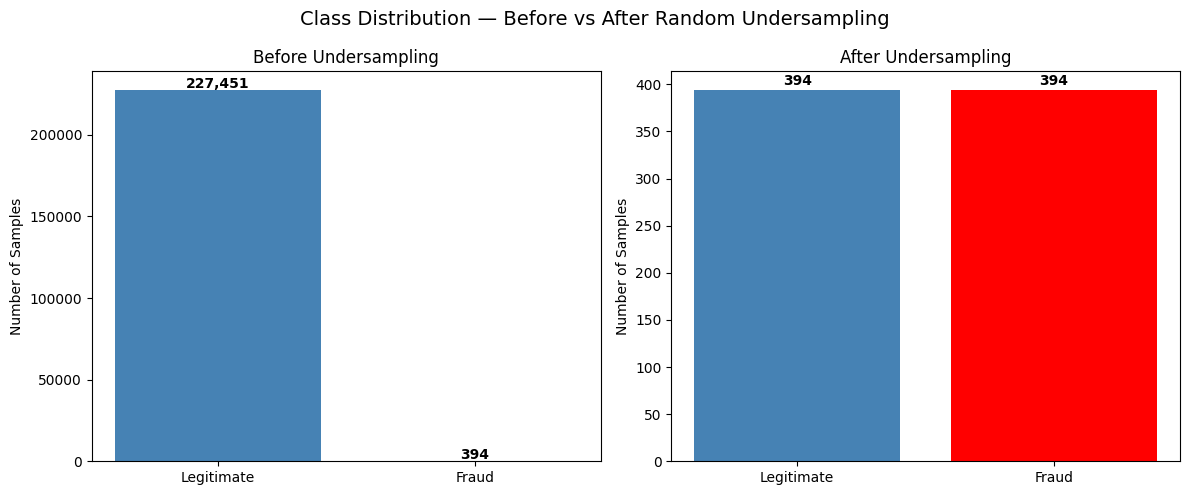

In [5]:
# Visualize: Before vs After Undersampling
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(["Legitimate", "Fraud"], [y_train.value_counts()[0], y_train.value_counts()[1]], color=["steelblue", "red"])
axes[0].set_title("Before Undersampling")
axes[0].set_ylabel("Number of Samples")
for i, v in enumerate([y_train.value_counts()[0], y_train.value_counts()[1]]):
    axes[0].text(i, v + 1000, f"{v:,}", ha="center", fontweight="bold")

axes[1].bar(["Legitimate", "Fraud"], [y_train_under.value_counts()[0], y_train_under.value_counts()[1]], color=["steelblue", "red"])
axes[1].set_title("After Undersampling")
axes[1].set_ylabel("Number of Samples")
for i, v in enumerate([y_train_under.value_counts()[0], y_train_under.value_counts()[1]]):
    axes[1].text(i, v + 5, f"{v:,}", ha="center", fontweight="bold")

plt.suptitle("Class Distribution — Before vs After Random Undersampling", fontsize=14)
plt.tight_layout()
plt.show()

## Class Weights

Unlike SMOTE and Undersampling which modify the data, Class Weights modify the **loss function** during training to make the model **pay more attention** to the minority class.

**How it works:**
- During training, each misclassification contributes to the loss (error) the model tries to minimize
- By default, misclassifying a fraud case and misclassifying a legitimate case are penalized **equally**
- With class weights, misclassifying a **fraud case is penalized much more heavily** (e.g., 577x more for our dataset)
- This forces the model to prioritize getting fraud cases right

**The `balanced` formula:**
```
weight = total_samples / (n_classes * class_count)

Legitimate weight = 284,807 / (2 * 284,315) = 0.5009
Fraud weight      = 284,807 / (2 * 492)     = 289.44
```
Misclassifying 1 fraud case costs the model ~**578x more** than misclassifying 1 legitimate case.

**Pros:**
- **No data modification** — uses the original dataset as-is, no synthetic samples or data loss
- **Simple** — just pass `class_weight="balanced"` to scikit-learn models
- **Works with any model** that supports it (Logistic Regression, Random Forest, SVM, XGBoost via `scale_pos_weight`)

**Cons:**
- Not all algorithms support class weights natively
- Can lead to more **false positives** (model becomes overly cautious, flagging legitimate transactions as fraud)
- Less control over the exact trade-off compared to threshold tuning

**SMOTE vs Undersampling vs Class Weights:**

| Approach | Data Modified? | Training Size | Risk |
|---|---|---|---|
| SMOTE | Yes (adds synthetic) | ~454K (2x fraud) | Synthetic noise, slower training |
| Undersampling | Yes (removes majority) | ~786 (tiny) | Information loss |
| Class Weights | No | ~227K (original) | More false positives |

In [11]:
from sklearn.utils.class_weight import compute_class_weight

# Compute balanced class weights
classes = np.array([0, 1])
weights = compute_class_weight("balanced", classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, weights))

print("Computed Class Weights (balanced)")
print("=" * 45)
print(f"  Legitimate (0): {class_weight_dict[0]:.4f}")
print(f"  Fraudulent (1): {class_weight_dict[1]:.4f}")
print(f"\n  Fraud penalty is {class_weight_dict[1] / class_weight_dict[0]:.1f}x higher than legitimate")

Computed Class Weights (balanced)
  Legitimate (0): 0.5009
  Fraudulent (1): 289.1434

  Fraud penalty is 577.3x higher than legitimate


## Evaluation: SMOTE vs Undersampling vs Class Weights

We train a **Logistic Regression** model with each approach and compare them on the **same test set** using fraud-relevant metrics: Recall, Precision, F1-Score, and PR-AUC.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_curve, auc, roc_auc_score,
    precision_score, recall_score, f1_score
)
import time

results = {}

# --- 1. SMOTE ---
start = time.time()
lr_smote = LogisticRegression(max_iter=1000, random_state=42)
lr_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = lr_smote.predict(X_test)
y_prob_smote = lr_smote.predict_proba(X_test)[:, 1]
train_time_smote = time.time() - start

precision_sm, recall_sm, _ = precision_recall_curve(y_test, y_prob_smote)
results["SMOTE"] = {
    "Precision": precision_score(y_test, y_pred_smote),
    "Recall": recall_score(y_test, y_pred_smote),
    "F1-Score": f1_score(y_test, y_pred_smote),
    "ROC-AUC": roc_auc_score(y_test, y_prob_smote),
    "PR-AUC": auc(recall_sm, precision_sm),
    "Train Time (s)": round(train_time_smote, 2)
}

# --- 2. Undersampling ---
start = time.time()
lr_under = LogisticRegression(max_iter=1000, random_state=42)
lr_under.fit(X_train_under, y_train_under)
y_pred_under = lr_under.predict(X_test)
y_prob_under = lr_under.predict_proba(X_test)[:, 1]
train_time_under = time.time() - start

precision_un, recall_un, _ = precision_recall_curve(y_test, y_prob_under)
results["Undersampling"] = {
    "Precision": precision_score(y_test, y_pred_under),
    "Recall": recall_score(y_test, y_pred_under),
    "F1-Score": f1_score(y_test, y_pred_under),
    "ROC-AUC": roc_auc_score(y_test, y_prob_under),
    "PR-AUC": auc(recall_un, precision_un),
    "Train Time (s)": round(train_time_under, 2)
}

# --- 3. Class Weights ---
start = time.time()
lr_cw = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42)
lr_cw.fit(X_train, y_train)
y_pred_cw = lr_cw.predict(X_test)
y_prob_cw = lr_cw.predict_proba(X_test)[:, 1]
train_time_cw = time.time() - start

precision_cw, recall_cw, _ = precision_recall_curve(y_test, y_prob_cw)
results["Class Weights"] = {
    "Precision": precision_score(y_test, y_pred_cw),
    "Recall": recall_score(y_test, y_pred_cw),
    "F1-Score": f1_score(y_test, y_pred_cw),
    "ROC-AUC": roc_auc_score(y_test, y_prob_cw),
    "PR-AUC": auc(recall_cw, precision_cw),
    "Train Time (s)": round(train_time_cw, 2)
}

# Display comparison
results_df = pd.DataFrame(results).T
results_df[["Precision", "Recall", "F1-Score", "ROC-AUC", "PR-AUC"]] = results_df[["Precision", "Recall", "F1-Score", "ROC-AUC", "PR-AUC"]].round(4)

print("Model Comparison: Logistic Regression")
print("=" * 75)
results_df

Model Comparison: Logistic Regression


,Precision,Recall,F1-Score,ROC-AUC,PR-AUC,Train Time (s)
SMOTE,0.0581,0.9184,0.1094,0.9698,0.7703,0.47
Undersampling,0.0384,0.9184,0.0738,0.9760,0.7172,0.00
Class Weights,0.0609,0.9184,0.1141,0.9722,0.7639,0.18


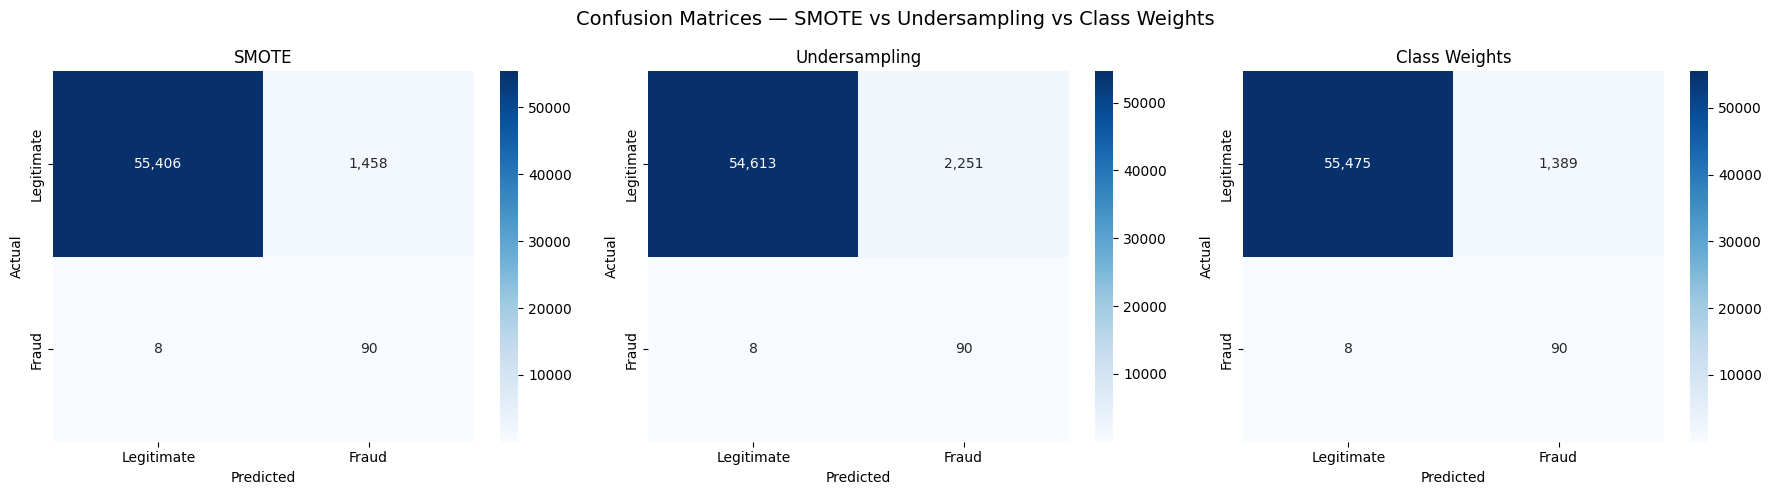

In [8]:
# Confusion Matrices side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, y_pred) in zip(axes, [("SMOTE", y_pred_smote), ("Undersampling", y_pred_under), ("Class Weights", y_pred_cw)]):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt=",d", cmap="Blues", ax=ax,
                xticklabels=["Legitimate", "Fraud"], yticklabels=["Legitimate", "Fraud"])
    ax.set_title(f"{name}")
    ax.set_ylabel("Actual")
    ax.set_xlabel("Predicted")

plt.suptitle("Confusion Matrices — SMOTE vs Undersampling vs Class Weights", fontsize=14)
plt.tight_layout()
plt.show()

**Confusion Matrix Breakdown**

| Metric | SMOTE | Undersampling | Class Weights |
|---|---|---|---|
| (actual legit → predicted legit) | 55,406 | 54,613 | 55,475 |
| (actual legit → predicted fraud) | 1,458 | 2,251 | 1,389 |
| (actual fraud → predicted legit) | 8 | 8 | 8 |
| (actual fraud → predicted fraud) | 90 | 90 | 90 |

**Few Observations**

1. Since our major goal is to classify the fraud cases. The point of concern will be if the fraud cases are classified as legit from our model. For the logistic regression model, for the three approaches there are 8 instances where the fraud cases were classified as legit.

2. If we are focussing on the model's ability in classifiying the acutal legit cases as fraud then Class Weights is the winner followed by SMOTE and then Undersampling. Class weights classifies only 1,389 legit cases as fraud, Undersampling classifies 2,251 legit cases as fraud. 
</br>
</br>
Now, Why this matters: Becasue if there is a genuine transaction present the model might flag it as fraud, leading to potential blocking of the transaction or throwing it for review. If at all the transactions are flagged for review then using Class weights we can have less reviews than Undersampling or SMOTE based approaches.

3. Precision is lowest across all the approaches.

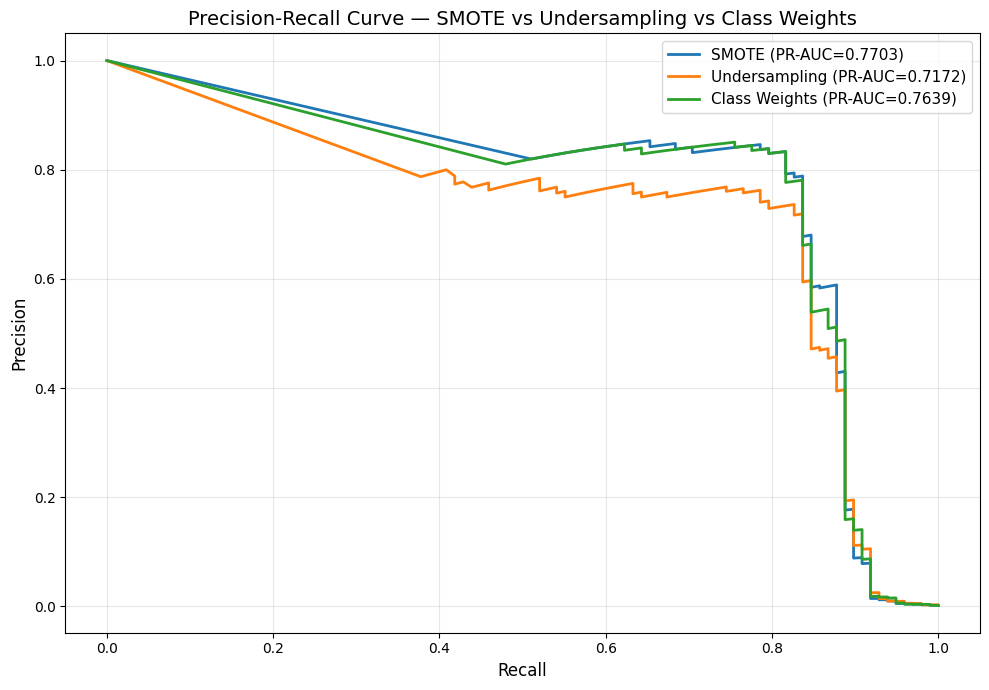

In [9]:
# Precision-Recall Curves comparison
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(recall_sm, precision_sm, label=f"SMOTE (PR-AUC={results['SMOTE']['PR-AUC']:.4f})", linewidth=2)
ax.plot(recall_un, precision_un, label=f"Undersampling (PR-AUC={results['Undersampling']['PR-AUC']:.4f})", linewidth=2)
ax.plot(recall_cw, precision_cw, label=f"Class Weights (PR-AUC={results['Class Weights']['PR-AUC']:.4f})", linewidth=2)

ax.set_xlabel("Recall", fontsize=12)
ax.set_ylabel("Precision", fontsize=12)
ax.set_title("Precision-Recall Curve — SMOTE vs Undersampling vs Class Weights", fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

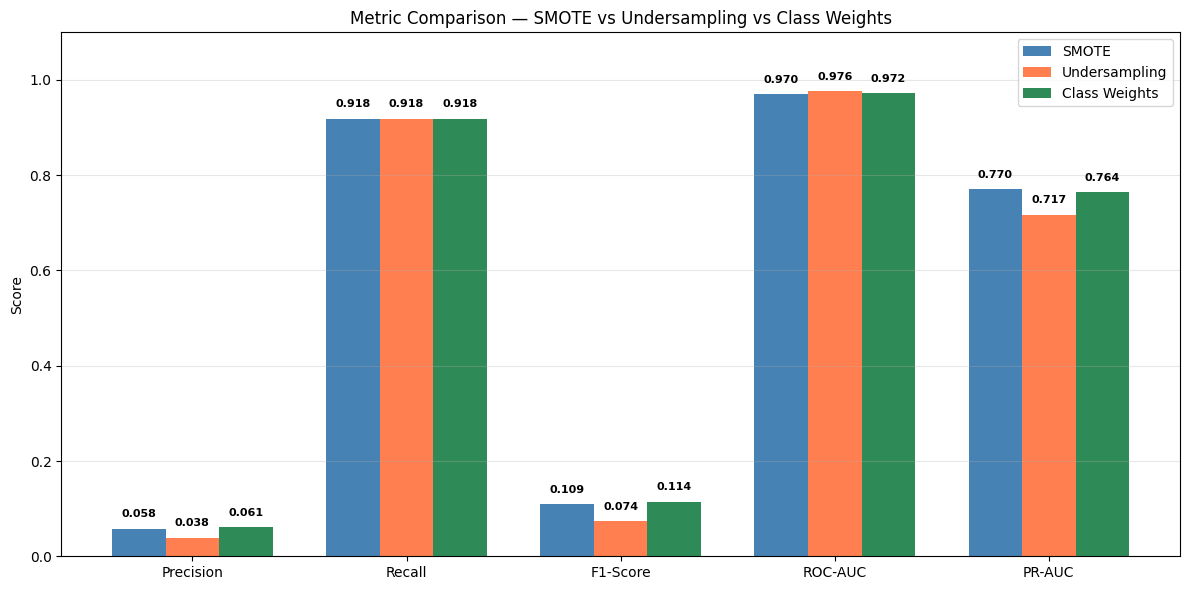

In [10]:
# Bar chart comparison of key metrics
metrics = ["Precision", "Recall", "F1-Score", "ROC-AUC", "PR-AUC"]
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width, [results["SMOTE"][m] for m in metrics], width, label="SMOTE", color="steelblue")
bars2 = ax.bar(x, [results["Undersampling"][m] for m in metrics], width, label="Undersampling", color="coral")
bars3 = ax.bar(x + width, [results["Class Weights"][m] for m in metrics], width, label="Class Weights", color="seagreen")

ax.set_ylabel("Score")
ax.set_title("Metric Comparison — SMOTE vs Undersampling vs Class Weights")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis="y", alpha=0.3)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height + 0.02, f"{height:.3f}",
                ha="center", va="bottom", fontsize=8, fontweight="bold")

plt.tight_layout()
plt.show()